<a href="https://colab.research.google.com/github/dorinhazan/FinalProject-DataScience/blob/main/final_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import warnings
import re
warnings.filterwarnings("ignore", category=UserWarning)

Merging Observable From Table And Repprts

In [ ]:
# Load the two JSON files
with open("/content/merged_with_gross_classification-reports.json", "r") as f:
    reports_json = json.load(f)

with open("/content/merged_with_gross_classification-table.json", "r") as f:
    table_json = json.load(f)

# Flatten all observables from the reports JSON (nested under report names)
merged_observables = []
for report in reports_json.values():
    merged_observables.extend(report.get("observables", []))

# Merge the flattened list with the list from the table JSON
merged_combined_list = merged_observables + table_json

output_path = "/content/merged_observables_combined.json"
with open(output_path, "w") as f:
    json.dump(merged_combined_list, f, indent=2)

output_path

'/content/merged_observables_combined.json'

Get the list of observable vlaues where "type": "malware"

In [ ]:
with open("/content/ics-attack.json", encoding="utf-8") as f:
    mitre_ics_data = json.load(f)

malware_name_set = set()

def _norm(s: str) -> str:
    """lower-case, strip, collapse whitespace -> 'stuxnet', 'blackenergy 3' …"""
    return re.sub(r'\s+', ' ', s).strip().lower()

for obj in mitre_ics_data.get("objects", []):
    if obj.get("type") == "malware":
        # primary name
        malware_name_set.add(_norm(obj["name"]))

In [ ]:
malware_pattern = re.compile(
    r'\b(?:' + '|'.join(map(re.escape, malware_name_set)) + r')\b',
    flags=re.I
)
retained_observables = []
removed_observables = []

for obs in merged_combined_list:
    fine_class = obs.get("fine_classification", "").lower()
    stix_val = obs.get("STIX_supported", "")
    observable_val = obs.get("observable_value", "").strip().lower()

    if (
        "malware" in fine_class or
        stix_val == "Full: Malware" or
        malware_pattern.search(observable_val)
    ):
        removed_observables.append(obs)
    else:
        retained_observables.append(obs)

# Save retained and removed observables to separate files
filtered_path = "/content/filtered_obs_table_reports.json"
removed_path = "/content/removed_malware_obs_table_reports.json"

with open(filtered_path, "w") as f:
    json.dump(retained_observables, f, indent=2)

with open(removed_path, "w") as f:
    json.dump(removed_observables, f, indent=2)

In [ ]:
with open("/content/filtered_obs_table_reports.json", "r") as f:
    all_observables = json.load(f)

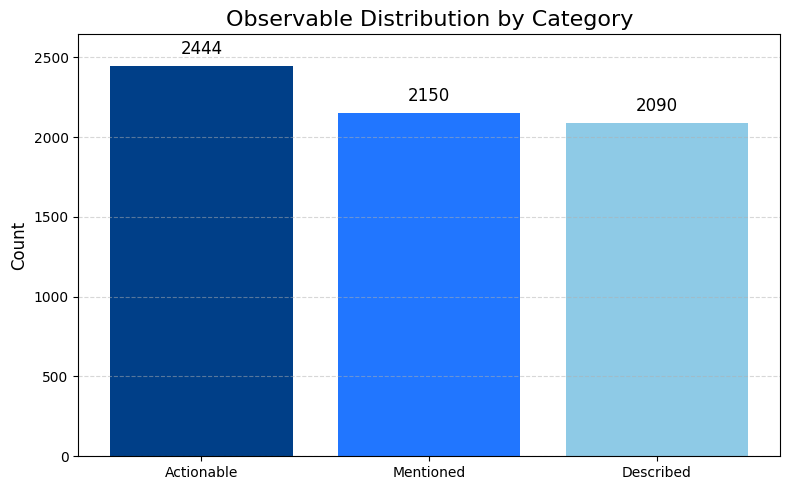

In [3]:
# Collect all artifact_details values
ranks = [obs.get("artifact_details") for obs in all_observables if obs.get("artifact_details")]

# Count each category
rank_counts = Counter(ranks)

# Plotting
categories = ['Actionable', 'Mentioned', 'Described']
values = [rank_counts.get(cat, 0) for cat in categories]

plt.figure(figsize=(8, 5))
bars = plt.bar(categories, values, color=['#003f88', '#2176ff', '#8ecae6'])

# Add count labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 50, f'{yval}', ha='center', va='bottom', fontsize=12)

plt.title("Observable Distribution by Category", fontsize=16)
plt.ylabel("Count", fontsize=12)
plt.ylim(0, max(values) + 200)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


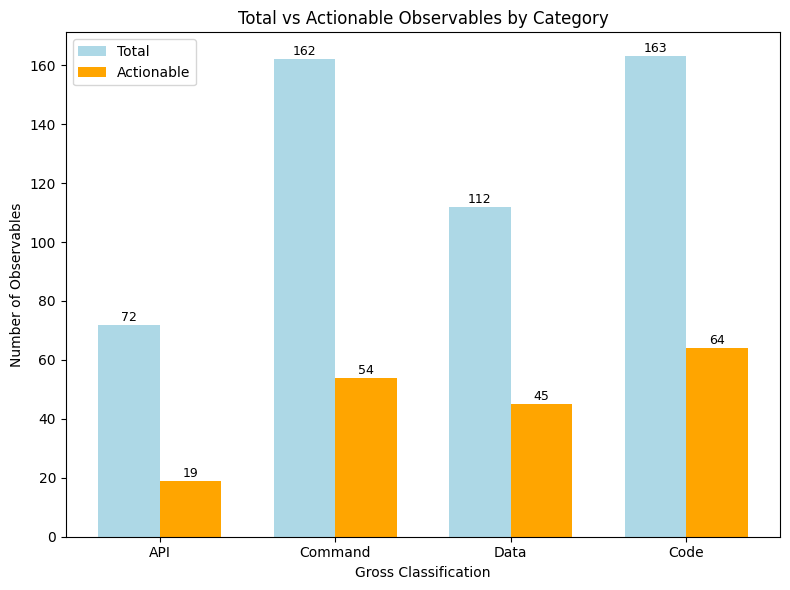

,gross_classification,total,actionable
0,API,72,19
1,Command,162,54
2,Data,112,45
3,Code,163,64


In [ ]:
# Define target gross_classification values
target_categories = {"Code", "Data", "API", "Command"}
actionable_keywords = {"Actionable"}

# Count total and actionable observables for each category
category_stats = []
for category in target_categories:
    total = sum(1 for obs in all_observables if obs.get("gross_classification") == category)
    actionable = sum(
        1 for obs in all_observables
        if obs.get("gross_classification") == category and obs.get("artifact_details") in actionable_keywords
    )
    category_stats.append({
        "gross_classification": category,
        "total": total,
        "actionable": actionable
    })

# Convert to DataFrame
df_category_stats = pd.DataFrame(category_stats)

plt.figure(figsize=(8, 6))
bar_width = 0.35
x = range(len(df_category_stats))

# Plot bars
bars_total = plt.bar(x, df_category_stats["total"], width=bar_width, label="Total", color='lightblue')
bars_actionable = plt.bar([p + bar_width for p in x], df_category_stats["actionable"], width=bar_width, label="Actionable", color='orange')

# Add labels on top of bars
for bar in bars_total:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.3, str(height), ha='center', va='bottom', fontsize=9)

for bar in bars_actionable:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.3, str(height), ha='center', va='bottom', fontsize=9)

# Labels and layout
plt.xlabel("Gross Classification")
plt.ylabel("Number of Observables")
plt.title("Total vs Actionable Observables by Category")
plt.xticks([p + bar_width / 2 for p in x], df_category_stats["gross_classification"])
plt.legend()
plt.tight_layout()
plt.show()
df_category_stats

In [ ]:
def analyze_gross_classifications(categories, observables, title_prefix=""):
    actionable_keywords = {"Actionable"}

    table_main = []
    table_stix_types = []
    table_non_supported_fine_classes = []

    for category in categories:
        category_observables = [obs for obs in observables if obs.get("gross_classification") == category]

        total = len(category_observables)
        actionable_count = sum(
            1 for obs in category_observables if obs.get("artifact_details") in actionable_keywords
        )
        stix_supported = [obs for obs in category_observables if obs.get("STIX_supported", "").strip().lower() != "no"]
        stix_supported_count = len(stix_supported)

        # Table 1: totals
        table_main.append({
            "gross_classification": category,
            "total_count": total,
            "actionable_count": actionable_count,
            "stix_supported_count": stix_supported_count
        })

        # Table 2: STIX object types
        stix_types = sorted(set(obs.get("STIX_supported") for obs in stix_supported))
        table_stix_types.append({
            "gross_classification": category,
            "stix_object_types": stix_types
        })

        # Table 3: fine classifications from unsupported
        stix_unsupported = [obs for obs in category_observables if obs.get("STIX_supported", "").strip().lower() == "no"]
        fine_classes = sorted(set(obs.get("fine_classification") for obs in stix_unsupported))
        table_non_supported_fine_classes.append({
            "gross_classification": category,
            "non_supported_fine_classifications": fine_classes
        })

    # Convert to DataFrames
    df_main = pd.DataFrame(table_main)
    df_stix_types = pd.DataFrame(table_stix_types)
    df_non_supported_fine = pd.DataFrame(table_non_supported_fine_classes)
    return df_main, df_stix_types, df_non_supported_fine

In [ ]:
# Run for task 2
categories_task2 = ["Cycle Time – new", "Measurement – new", "SCADA – new"]
df_main2, df_stix_types2, df_non_supported_fine2 = analyze_gross_classifications(categories_task2, all_observables)

# Run for task 3 (categories containing "ICS")
categories_task3 = sorted(set(
    obs["gross_classification"] for obs in all_observables
    if "ICS" in obs.get("gross_classification", "")
))
df_main3, df_stix_types3, df_non_supported_fine3 = analyze_gross_classifications(categories_task3, all_observables)

In [ ]:
# Final version of the grouped display function based on your refined requirements
def display_refined_analysis_tables(df_main, df_stix_types, df_non_supported_fine, title_prefix=""):
    # Table 1 – Combined summary
    summary_table = df_main.rename(columns={
        "gross_classification": "Gross Classification",
        "total_count": "Total Observables",
        "actionable_count": "Actionable Observables",
        "stix_supported_count": "STIX-Supported Observables"
    })

    # Table 2 – Only classifications with STIX-supported values
    stix_supported_only = df_stix_types[df_stix_types["stix_object_types"].map(len) > 0].copy()
    stix_supported_only = stix_supported_only.rename(columns={
        "gross_classification": "Gross Classification",
        "stix_object_types": "STIX Support Types"
    })

    # Table 3 – Only classifications with STIX unsupported
    stix_unsupported_only = df_non_supported_fine[df_non_supported_fine["non_supported_fine_classifications"].map(len) > 0].copy()
    stix_unsupported_only = stix_unsupported_only.rename(columns={
        "gross_classification": "Gross Classification",
        "non_supported_fine_classifications": "Fine Classifications (STIX Unsupported)"
    })

    # Apply unified styling
    def styled_aligned_table(df, subtitle):
        return (
            df.style
            .set_caption(subtitle)
            .set_table_styles([
                {'selector': 'caption',
                 'props': [('font-size', '18px'), ('font-weight', 'bold'), ('text-align', 'left'), ('margin-bottom', '10px')]},
                {'selector': 'th',
                 'props': [('text-align', 'left'), ('background-color', '#f2f2f2')]},
                {'selector': 'td',
                 'props': [('text-align', 'left'), ('white-space', 'pre-wrap')]}
            ])
            .set_properties(**{
                'border': '1px solid black',
                'padding': '6px',
                'vertical-align': 'top'
            })
        )

    # Section header for the group of classifications
    display(HTML(f"<h2 style='text-align: left; font-size: 20px;'>📚 Gross Classifications: {title_prefix}</h2>"))

    # Display all three tables
    display(styled_aligned_table(summary_table, "Summary of Observables by Gross Classification"))
    display(styled_aligned_table(stix_supported_only, "STIX Support Types per Gross Classification"))
    display(styled_aligned_table(stix_unsupported_only, "Fine Classifications from STIX Unsupported Observables"))

# Execute with cleaned, grouped section headers
from IPython.display import HTML

display_refined_analysis_tables(df_main2, df_stix_types2, df_non_supported_fine2, title_prefix="Cycle Time – new, Measurement – new, SCADA – new")
display_refined_analysis_tables(df_main3, df_stix_types3, df_non_supported_fine3, title_prefix="ICS-related classifications")


,Gross Classification,Total Observables,Actionable Observables,STIX-Supported Observables
0,Cycle Time – new,7,0,0
1,Measurement – new,2,0,0
2,SCADA – new,14,3,2


,Gross Classification,STIX Support Types
2,SCADA – new,"['Full: Software', 'Partial']"


,Gross Classification,Fine Classifications (STIX Unsupported)
0,Cycle Time – new,"['Cycle Time Limit', 'Cycle Time Measurement', 'Cycle Time Percentage', 'Default Cycle Time', 'Worm Cycle Time']"
1,Measurement – new,"['Measurement Reading', 'Measurement Unit']"
2,SCADA – new,"['RTU Command', 'Remote Terminal Unit', 'Rotor Speed', 'SCADA Display', 'SCADA Display Indicator', 'SCADA Display Label', 'SCADA System', 'SCADA UI Label']"


,Gross Classification,Total Observables,Actionable Observables,STIX-Supported Observables
0,ICS Attack – new,2,1,1
1,ICS Endpoint – new,3,0,0
2,ICS Function – new,1,0,0
3,ICS I/O Snapshot – new,1,0,0
4,ICS Object – new,2,0,0
5,ICS Tags – new,10,0,0


,Gross Classification,STIX Support Types
0,ICS Attack – new,['Full: Tool']


,Gross Classification,Fine Classifications (STIX Unsupported)
0,ICS Attack – new,['ICS Attack Module']
1,ICS Endpoint – new,['ICS Endpoint']
2,ICS Function – new,['ICS Function']
3,ICS I/O Snapshot – new,['ICS I/O Snapshot']
4,ICS Object – new,['ICS Object']
5,ICS Tags – new,"['ICS Mode', 'ICS Status Code', 'ICS Tag']"


In [ ]:
# Filter observables with "gross_classification": "ICS Tags – new"
ics_tags_observables = [
    obs for obs in all_observables if obs.get("gross_classification") == "ICS Tags – new"
]

# Count how many there are
ics_tags_count = len(ics_tags_observables)

# Extract and count unique "data_source" values
data_sources = [obs.get("data_source", "N/A") for obs in ics_tags_observables]
data_source_counts = Counter(data_sources)

# Create styled table
summary_df = pd.DataFrame([{
    "Gross Classification": "ICS Tags – new",
    "Total Observables": ics_tags_count
}])

data_source_df = pd.DataFrame.from_dict(data_source_counts, orient="index", columns=["Count"])
data_source_df.index.name = "Data Source"
data_source_df.reset_index(inplace=True)

# Styling function
def styled_table(df, title):
    return (
        df.style
        .set_caption(title)
        .set_table_styles([
            {'selector': 'caption',
             'props': [('font-size', '18px'), ('font-weight', 'bold'), ('text-align', 'left'), ('margin-bottom', '10px')]},
            {'selector': 'th',
             'props': [('text-align', 'left'), ('background-color', '#f2f2f2')]},
            {'selector': 'td',
             'props': [('text-align', 'left'), ('white-space', 'pre-wrap')]}
        ])
        .set_properties(**{
            'border': '1px solid black',
            'padding': '6px',
            'vertical-align': 'top'
        })
    )

# Display both tables
display(styled_table(summary_df, "📊 Summary – ICS Tags – new"))
display(styled_table(data_source_df, "📘 Data Source"))

,Gross Classification,Total Observables
0,ICS Tags – new,10


,Data Source,Count
0,None,3
1,ICS historian,6
2,ICS Data,1


,Total Count - STIX Supported = Partial,Total Count - Actionable Observables (Partial)
0,634,253


,Gross Classification,Count
0,Cryptographic Hash – new,63
1,File,27
2,Registry – new,19
3,Identifier,16
4,Software,16
5,Connection Port,14
6,Code,13
7,PLC,10
8,Service,10
9,Data,8


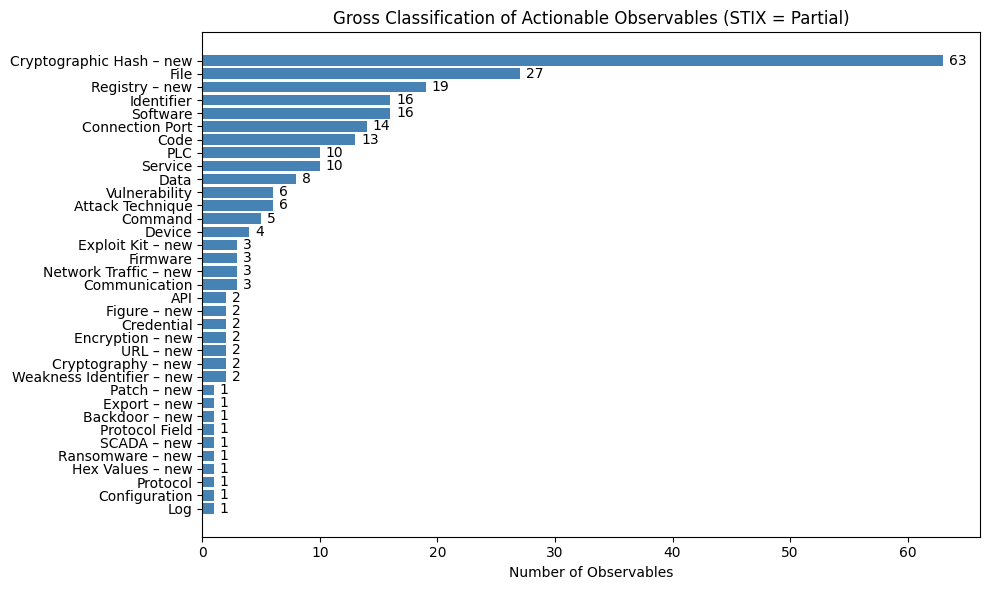

,Fine Classification,Count
0,Registry Value,16
1,Software/Tool,15
2,Hash,15
3,File Extension Pattern,14
4,MD5 hash,13
5,SHA256 hash,13
6,SHA1 hash,13
7,Network Port,11
8,Bitcoin Address,10
9,SHA-1 Hash,9


In [ ]:
# Step 5.1: Filter observables with STIX_supported == "Partial"
partial_stix_observables = [obs for obs in all_observables if obs.get("STIX_supported") == "Partial"]

# Further filter to those that are actionable
actionable_partial_stix = [obs for obs in partial_stix_observables if obs.get("artifact_details") == "Actionable"]
total_partial = len(partial_stix_observables)
actionable_partial_count = len(actionable_partial_stix)

# Create summary table
summary_df = pd.DataFrame([{
    "Total Count - STIX Supported = Partial": total_partial,
    "Total Count - Actionable Observables (Partial)": actionable_partial_count
}])

# Count gross_classification from actionable
gross_class_counts = Counter(obs.get("gross_classification", "Unknown") for obs in actionable_partial_stix)
df_gross_class = pd.DataFrame(gross_class_counts.items(), columns=["Gross Classification", "Count"])
df_gross_class = df_gross_class.sort_values(by="Count", ascending=False)

# Count top fine_classification values
fine_class_counts = Counter(obs.get("fine_classification", "Unknown") for obs in actionable_partial_stix)
df_fine_class = pd.DataFrame(fine_class_counts.items(), columns=["Fine Classification", "Count"])
df_fine_class = df_fine_class.sort_values(by="Count", ascending=False).head(20)

# Styled table display
def styled_table(df, title):
    return (
        df.style
        .set_caption(title)
        .set_table_styles([
            {'selector': 'caption',
             'props': [('font-size', '18px'), ('font-weight', 'bold'), ('text-align', 'left'), ('margin-bottom', '10px')]},
            {'selector': 'th',
             'props': [('text-align', 'left'), ('background-color', '#f2f2f2')]},
            {'selector': 'td',
             'props': [('text-align', 'left'), ('white-space', 'pre-wrap')]}
        ])
        .set_properties(**{
            'border': '1px solid black',
            'padding': '6px',
            'vertical-align': 'top'
        })
    )
display(styled_table(summary_df, "📘 Summary: STIX = Partial"))

display(styled_table(df_gross_class.reset_index(drop=True), "📘 Gross Classification – Actionable Observables (STIX = Partial)"))
plt.figure(figsize=(10, 6))
bars = plt.barh(df_gross_class["Gross Classification"], df_gross_class["Count"], color='steelblue')
plt.xlabel("Number of Observables")
plt.title("Gross Classification of Actionable Observables (STIX = Partial)")

# Add text labels to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height() / 2, str(int(width)), va='center')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Display styled summary and results
display(styled_table(df_fine_class.reset_index(drop=True), "📘 Top 20 Fine Classifications – Actionable Observables (STIX = Partial)"))
